### Mean-Variance Potfolio Optimization with Elastic Net Penalty

TO-DO
- Compare OOS performance of split-bregman using normal params and regularized params
- Compare OOS performance of optimal split bregman against mean variance optimal; equally weighted 


In [82]:
import itertools
import numpy as np
import pandas as pd
import scipy.optimize
from qpsolvers import solve_qp
from scipy.sparse import csc_matrix, csc_array
import matplotlib.pyplot as plt

###  Returns below
- Note log returns have caused some issues numerically within optimiztion

In [83]:
equity_data=pd.read_csv('equity_data_2010_2020.csv')
equity_data.index=equity_data['Date']
equity_data=equity_data.drop(columns=['Date'])


returns=np.log(equity_data/equity_data.shift(1))
returns=returns.fillna(0)
returns=returns.iloc[1:]
frac=0.5
cutoff=np.floor(frac*len(returns.index)).astype(int)

returns_train=returns.iloc[:cutoff]
returns_test=returns.iloc[cutoff:]

returns_train

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,-0.006283,-0.012860,-0.008112,0.000000,-0.024321,0.006161,0.001768,0.005387,0.016313,-0.005385,...,-0.002244,0.000411,0.059041,-0.011930,0.000000,-0.003426,-0.001745,0.031165,0.034651,0.000000
2010-01-06,0.014082,0.000454,0.005538,0.000000,-0.015358,0.010575,-0.005314,-0.002532,-0.002124,-0.002350,...,0.015971,0.003796,-0.013204,0.001919,0.000000,-0.007175,-0.007717,-0.000323,0.083382,0.000000
2010-01-07,0.000717,0.002946,0.008250,0.000000,0.000000,-0.000935,-0.024271,-0.010511,-0.019595,-0.000471,...,-0.002952,0.009377,0.021131,-0.004322,0.000000,-0.000288,-0.025318,0.022681,0.106160,0.000000
2010-01-08,0.007022,0.014602,0.005099,0.000000,-0.020446,-0.003986,-0.008223,-0.012567,-0.005436,-0.001414,...,-0.001109,0.011700,-0.007191,0.000481,0.000000,0.000288,-0.003256,-0.021228,-0.016320,0.000000
2010-01-11,-0.004040,-0.004694,0.005073,0.000000,-0.018394,-0.000940,-0.000918,0.000648,-0.013169,0.004469,...,0.009939,0.004203,-0.003245,0.009574,0.000000,0.017133,0.003256,0.021860,0.006075,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24,0.000539,0.003030,-0.000438,0.028495,0.003386,-0.001094,0.005914,-0.001129,0.004828,0.000822,...,-0.000883,-0.003186,-0.005222,0.022329,0.001032,0.001512,0.003197,0.005624,-0.000351,0.020044
2014-12-26,-0.004202,0.007623,0.003277,0.011563,0.004669,-0.000657,0.003434,0.005820,-0.000937,-0.000469,...,-0.000442,0.000428,-0.003518,0.009614,0.004890,0.004797,-0.002941,0.000526,0.001402,0.008178
2014-12-29,0.002703,0.000883,-0.005467,0.002386,-0.004149,-0.008142,-0.002943,-0.005443,-0.007258,-0.003881,...,-0.003320,0.006861,0.017339,0.018150,-0.002313,0.005726,-0.000640,-0.005886,0.005587,-0.004308


### Computation of Naive mean and covariance estimation from sample

In [84]:
returns_mean=returns_train.mean().values
returns_cov=np.cov(returns_train.T)

Text(0, 0.5, 'Freq')

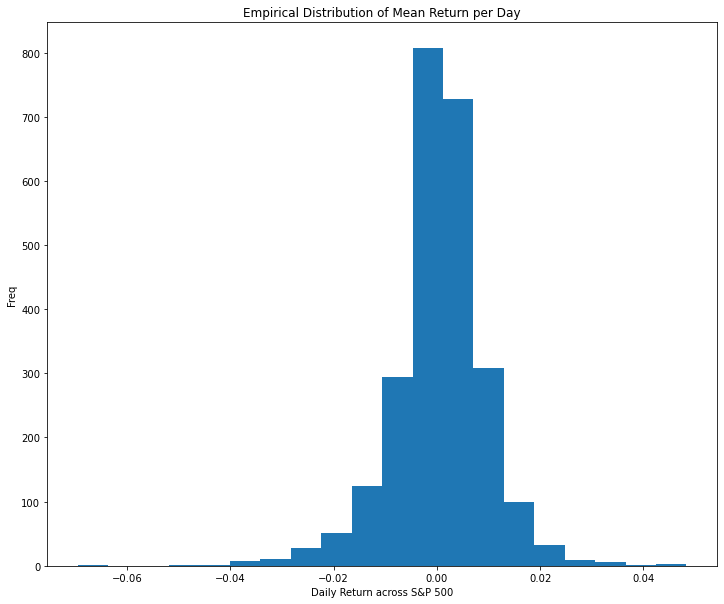

In [85]:
fig,ax=plt.subplots(figsize=(12,10))
bins=plt.hist(returns.mean(axis=1),bins=20)
plt.title("Empirical Distribution of Mean Return per Day")
plt.xlabel("Daily Return across S&P 500")
plt.ylabel("Freq")

Text(0.5, 1.0, 'Singular Values of Covariance Matrix')

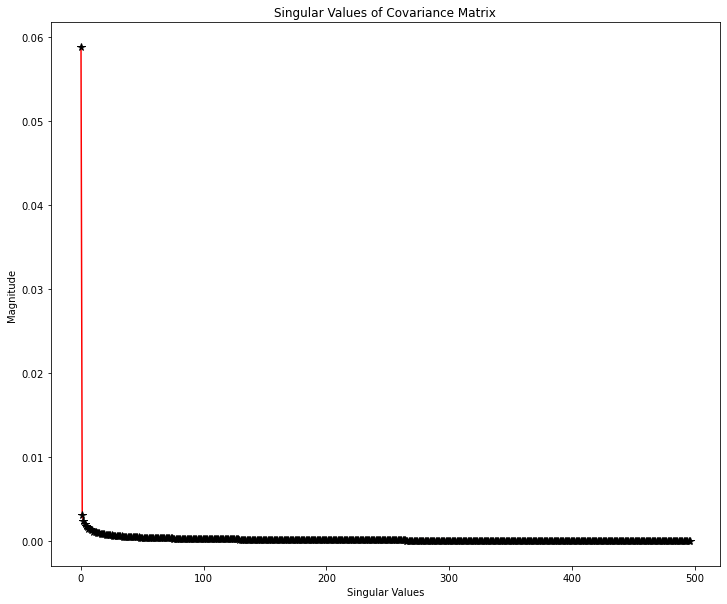

In [86]:
u,s,v=np.linalg.svd(returns_cov)
fig,ax=plt.subplots(figsize=(12,10))
bins=plt.plot(s,marker='*',color='red',markersize=7.5,mfc='black',mec='black')
plt.xlabel('Singular Values')
plt.ylabel('Magnitude')
plt.title("Singular Values of Covariance Matrix")

### Regularized Mean and Covariance Estimators 

In [87]:
def james_stein(mu):
    pass


def reg_cov(cov,penalty=0.25):
    return (1-penalty)*cov+penalty*np.identity(cov.shape[0])

returns_cov=reg_cov(returns_cov)

### Application of Sparse Solver Split Bregman Operator

Utilizes nested optimization routine where
- Inner Optimization is unconstrained QP problem involving L2 penalty
    - Can solve numerically via unconstrained minimization
    - Solve analytically via QPSolvers
- Applies shrinkage (L1) penalty within outer loop


Interesting results in normalization of w vector

In [122]:
def qp(cov,mean,w,d,b,beta,lambda2,tol,maxiter,approach,verbose=True):
    """ Inner optimization problem using unconstrained optimization 
        Approach "numerical" solves numerically via unconstrained minimization
        Approach "closed-form" solves analytically via cvxopt within qpsolvers 
        Support for standard mean variance optimization (approach=2; pen=False)
    """
    
    x0=w # initial guess is previous result
    if approach=="numerical":
        def objective_val(w,cov,mean,d,b,beta,lambda2):
            obj=np.dot(np.dot(w,cov),w)-np.dot(w,mean)
            l2_pen=np.sum((d-beta*w-b)**2)
            return obj+lambda2*l2_pen/2

        res=scipy.optimize.minimize(objective_val,x0=w,args=(returns_cov,returns_mean,d,b,beta,lambda2),method='CG',options={'maxiter':25},tol=1e-12)
        w=res.x
        
    if approach=="closed-form":
        w_old=w

        # define objective function with l2 penalty
        quad=csc_matrix((cov+lambda2*np.diag(d-b)))
        linear=-1*mean
        
        # constrain solution vector to be unit norm and non-negative
        A=np.ones(len(mean))
        constraint=np.array([1.0])
        w = solve_qp(quad,linear.reshape(len(linear),),A=A,b=constraint,initvals=x0, solver="cvxopt")
        
        if w is None:
            print("QP Optimization fails")
            return w_old
        
        # factor into the intercept for closed form QP
        w=w+d-b
    return w

def shrinkage(w,b,lambda1,beta):
    """ Applies one-sided soft-thresholding operator that is equivalent to L1 penalization 
    """
    
    if lambda1==0:
        return np.zeros(len(w))
    x=beta*w+b
    obj=np.fmax([np.abs(x)-(1/lambda1)],[np.zeros(len(w))])  
    signed_obj=np.sign(x)*obj

    return signed_obj[0]

def split_bregman(cov,mean,lambda1,lambda2,beta=None,tol=1e-10,maxiter=100,approach=2,verbose=True):
    """ Split Bregman Optimization Routine
    """

    total_cost=1
    n=len(mean)
    if beta is None:
        beta=np.ones(n)
    
    b=np.zeros(n)
    w=np.zeros(n)
    d=np.zeros(n)
    
    i=0
    while total_cost>tol:
        if i>maxiter:
            if verbose:
                print("MaxIter Achieved")
            break
        
        # solve qp problem either closed form or numerically
        w=qp(cov,mean,w,d,b,beta,lambda2,tol,maxiter,approach)
 
        # solve for sparse vector near previous optimal solution
        d=shrinkage(w,b,lambda1,beta)
        b=b+beta*w -d 
        i+=1

        # compute total cost
        total_cost=np.dot(np.dot(w,cov),w)-np.dot(w,mean)+(lambda1*np.sum(np.abs(w))+lambda2*np.sum((w)**2))/2
        if verbose:
            print(f"Total Cost: {total_cost}")

    if sum(abs(w))==0:
        return w,total_cost
    
    unit_w=w/sum(abs(w))
    return unit_w, total_cost

### Numerical Results

Unit Tests
- Solve Optimal solution both closed form and numerically


### Test 1: Equal Penalties Closed Form and Numerically

In [129]:
lambda1=1
lambda2=1
w_numerical,error_numerical=split_bregman(returns_cov,returns_mean,lambda1=lambda1,lambda2=lambda2,tol=1e-6,maxiter=25,approach="numerical",verbose=True)
w_numerical

Total Cost: 0.09431107153920701
Total Cost: 0.03430140446075304
Total Cost: 0.01251350104578588
Total Cost: 0.0045740155426527715
Total Cost: 0.0016758329452487982
Total Cost: 0.0006141059370825458
Total Cost: 0.0002254575151975434
Total Cost: 8.327299407234557e-05
Total Cost: 3.0582998168863156e-05
Total Cost: 1.3118801709829798e-05
Total Cost: 4.891285534095372e-06
Total Cost: 1.7163239884090055e-06
Total Cost: 1.4511617506341017e-06
Total Cost: 5.289165647730904e-07


array([-1.89354478e-03, -3.30221897e-03, -1.39320288e-03, -1.31359320e-03,
       -3.61456333e-03, -2.03282891e-03, -1.60433929e-03, -1.57234208e-03,
       -2.01710662e-03, -2.02535060e-03, -3.04737818e-03, -8.17383473e-04,
       -1.39852374e-03, -2.15420752e-03, -1.68647200e-03, -2.56801078e-03,
       -4.44598164e-03, -1.81279093e-03, -1.34153229e-03, -3.01002410e-03,
       -3.37785926e-04, -1.90951008e-03, -2.19860038e-03, -1.59229884e-03,
       -1.58126251e-03, -2.01879187e-03, -2.30951859e-03, -6.80479106e-04,
        1.23611881e-03, -1.36835935e-03, -5.55440189e-03, -1.38704052e-03,
       -2.29976570e-03, -2.17228127e-03, -2.05690237e-03, -1.98508403e-03,
       -3.26207426e-03, -2.74095231e-03, -2.90229663e-03, -2.39206177e-03,
       -2.41237513e-03, -1.77981659e-03, -1.85019437e-03, -2.28190323e-03,
        1.37835540e-04, -2.91491842e-03, -1.83835679e-03, -2.58246372e-03,
       -2.09797109e-03, -2.64450639e-04, -1.92086605e-03, -2.18151203e-03,
       -6.69078487e-04, -

In [130]:
lambda1=1
lambda2=1
w_cf,error_cf=split_bregman(returns_cov,returns_mean,lambda1=lambda1,lambda2=lambda2,tol=1e-6,maxiter=25,approach="closed-form",verbose=True)
w_cf

Total Cost: 0.524594654835064
Total Cost: 0.005527681401902787
Total Cost: 8.875092015325061e-05
Total Cost: 1.8927213083070296e-06
Total Cost: 4.587469564523996e-08


array([-1.22340557e-03, -5.04352710e-04, -1.12031006e-03, -1.22760481e-03,
        6.12564616e-04, -1.29362048e-03, -1.16225885e-03, -1.04421674e-03,
       -1.24046686e-03, -1.33195273e-03,  2.21676380e-04, -7.40938907e-04,
       -8.41590426e-04, -1.14002838e-03, -1.10185405e-03, -1.42892047e-03,
        1.23772353e-02, -1.01033440e-03, -9.17424860e-04, -1.40099831e-03,
       -8.33292549e-04, -1.31316079e-03, -1.33506441e-03, -1.09615779e-03,
       -1.09114940e-03, -1.34838691e-03, -1.43803056e-03, -9.93793071e-04,
       -4.53511544e-03, -1.06399204e-03,  5.14717846e-02, -1.10969603e-03,
       -1.34658417e-03, -1.14227869e-03, -1.36804282e-03, -1.35699332e-03,
       -1.20746387e-03, -7.99034227e-04, -1.30478461e-03, -1.39186722e-03,
       -1.36221174e-03, -1.11869235e-03, -1.16569676e-03, -1.38849456e-03,
       -5.59528989e-04, -5.10816318e-04, -1.11274697e-03, -6.14837426e-04,
       -1.37045658e-03, -8.16874221e-04, -1.30253445e-03, -1.32448134e-03,
       -8.23554776e-04, -

### Comparisons of Optimal Solution

In [137]:
w_numerical.shape

(497,)

Text(0, 0.5, 'Weight Allocation')

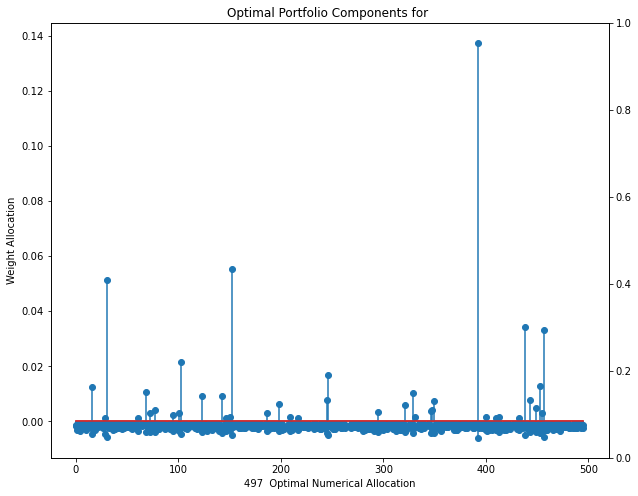

In [139]:
threshold=0.001

optimal_numerical=np.where(abs(w_numerical)>threshold)[0]
optimal_cf=np.where(abs(w_cf)>threshold)[0]
fig,ax=plt.subplots(figsize=(10,8))
plt.title("Optimal Portfolio Components for ")
ax.stem(optimal_numerical,w_numerical[optimal_numerical])
ax2=ax.twinx()
ax.stem(optimal_cf,w_cf[optimal_cf])
ax.set_xlabel(f"{len(w_numerical)}  Optimal Numerical Allocation")
ax2.set_xlabel(f"{len(w_cf)}  Optimal Closed Form Allocation")
ax.set_ylabel("Weight Allocation")

### Grid Search for Optimal Lambda Values 
- Cross valaidate optimal $\lambda_1$ and $\lambda_2$ parameters representing L1 and L2 regularization

In [429]:
def grid_search(params,returns_mean,returns_cov,tol=1e-8,maxiter=25):
    results={}
    for i in params:
        lambda1,lambda2=i
        w,error=split_bregman(returns_cov,returns_mean,lambda1,lambda2,tol=1e-8,maxiter=100,approach=2)
        if max(abs(w))==0:
            continue
        results[i]=(w,error)
    sorted_dict=sorted(results.items(), key=lambda x:x[1][1])
    return sorted_dict

lambda1_grid=np.logspace(0,8,5)
lambda2_grid=np.logspace(-4,4,5)

params=[]
for i in itertools.product(lambda1_grid,lambda2_grid):
    params.append(i)

sorted_dict=grid_search(params,returns_mean,returns_cov)

25-th iteration with error of 1.0026207216403082
50-th iteration with error of 1.0026207216403082
75-th iteration with error of 1.0026207216403082
100-th iteration with error of 1.0026207216403082
MaxIter Achieved
Terminated in 101 iterations of error 1.0026207216403082 for lambda1=1.0 and lambda2=0.0001
25-th iteration with error of 1.0026056166855477
50-th iteration with error of 1.0026056166855557
75-th iteration with error of 1.0026056166855557
100-th iteration with error of 1.0026056166855557
MaxIter Achieved
Terminated in 101 iterations of error 1.0026056166855557 for lambda1=1.0 and lambda2=0.01
25-th iteration with error of 1.0042768964237558
50-th iteration with error of 1.0045112488468053
75-th iteration with error of 1.0049174849085791
100-th iteration with error of 1.0045076088140932
MaxIter Achieved
Terminated in 101 iterations of error 1.0038879657763486 for lambda1=1.0 and lambda2=1.0
25-th iteration with error of 1.004982143792941
50-th iteration with error of 1.0039677

Text(0, 0.5, 'Weight Allocation')

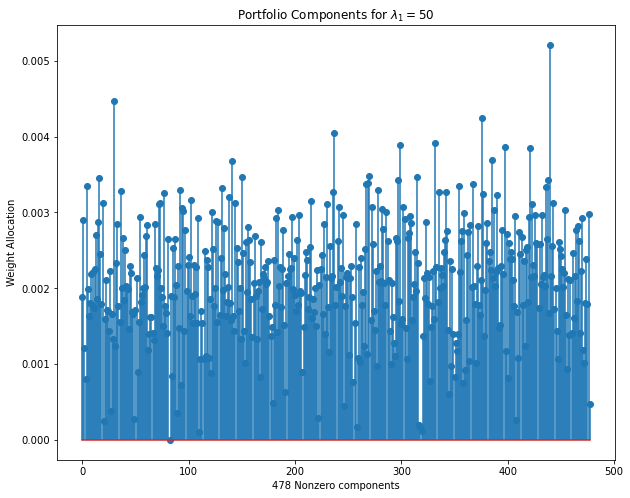

In [430]:
wi=sorted_dict[0][1][0]
nonzero_wi=np.where(abs(wi)>0)[0]

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for $\lambda_1=50$")
ax.stem(wi[nonzero_wi])
plt.xlabel(f"{len(wi[nonzero_wi])} Nonzero components")
plt.ylabel("Weight Allocation")

In [431]:
print(f"Largest Component is {max(abs(wi[nonzero_wi]))}")
print(f"Smallest Component is {min(abs(wi[nonzero_wi]))}")

Largest Component is 0.005210129895797403
Smallest Component is 4.459999910800002e-06


### Mean Variance Objective

- Constrains to expected returns of portfolio off sample mean
-  We can solve this by setting penalty values respectively to 0
- Requires a regularized matrix otherwise problem is ill-defined (due to rank)

In [504]:
lambda1=0
lambda2=0

w_opt,error3_opt=split_bregman(returns_cov,returns_mean,lambda1=lambda1,lambda2=lambda2,tol=1e-8,maxiter=100,approach=2)

25-th iteration with error of 1.0043886540045541
50-th iteration with error of 1.0043886540045541
75-th iteration with error of 1.0043886540045541
100-th iteration with error of 1.0043886540045541
MaxIter Achieved
Terminated in 101 iterations of error 1.0043886540045541 for lambda1=0 and lambda2=0


Text(0, 0.5, 'Weight Allocation')

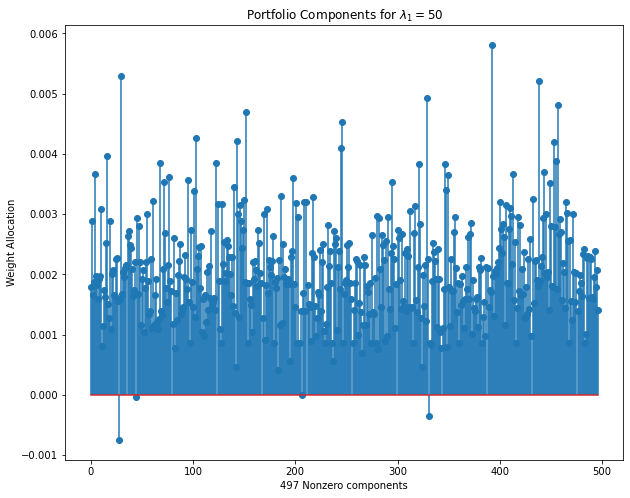

In [505]:

nonzero_w_opt=np.where(abs(w_opt)>0)[0]

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for $\lambda_1=50$")
ax.stem(w_opt[nonzero_w_opt])
plt.xlabel(f"{len(w_opt[nonzero_w_opt])} Nonzero components")
plt.ylabel("Weight Allocation")

### Minimum Variance Objective

- Solve QP only problem
- Pass in mean vector of 0's

In [506]:
lambda1=0
lambda2=0
mean=np.zeros(returns_cov.shape[0])


w_minvar,error_minvar=split_bregman(returns_cov,mean,lambda1=lambda1,lambda2=lambda2,tol=1e-8,maxiter=100,approach=2)

25-th iteration with error of 1.0025953732387232
50-th iteration with error of 1.0025953732387232
75-th iteration with error of 1.0025953732387232
100-th iteration with error of 1.0025953732387232
MaxIter Achieved
Terminated in 101 iterations of error 1.0025953732387232 for lambda1=0 and lambda2=0


Text(0, 0.5, 'Weight Allocation')

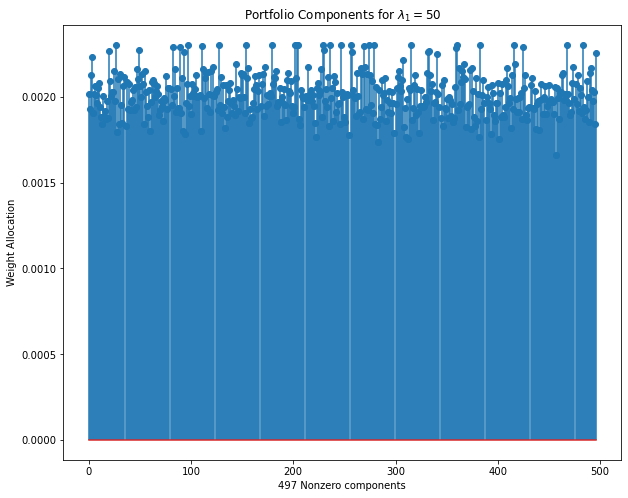

In [507]:
nonzero_w_minvar=np.where(abs(w_minvar)>0)[0]

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for $\lambda_1=50$")
ax.stem(w_minvar[nonzero_w_minvar])
plt.xlabel(f"{len(w_opt[nonzero_w_minvar])} Nonzero components")
plt.ylabel("Weight Allocation")

### Evaluation Criteria

In [437]:
returns_test

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,-0.001582,-0.007091,-0.002665,0.006876,-0.019706,-0.005263,-0.000993,0.000385,-0.004952,-0.000960,...,-0.005802,0.001295,-0.012571,0.005568,0.000263,-0.006863,0.000258,-0.007318,-0.007717,0.006507
2015-01-05,-0.022553,-0.017497,0.000223,-0.018819,-0.006433,-0.016884,-0.013910,-0.034602,-0.004976,-0.000720,...,-0.007183,-0.024450,-0.017020,-0.011351,-0.062237,-0.020318,-0.014077,0.037304,-0.037469,-0.006003
2015-01-06,-0.010664,-0.008177,-0.011356,-0.004950,-0.025357,-0.007213,-0.018640,-0.019713,-0.020145,-0.008290,...,-0.004974,-0.014178,-0.021331,0.005321,-0.005881,-0.012274,-0.007205,-0.008477,-0.038193,-0.009756
2015-01-07,0.007249,0.007329,0.008108,0.040417,0.031829,0.020990,-0.021561,0.015032,0.008223,0.008723,...,0.014315,0.000896,0.029368,0.008635,0.007887,0.033138,0.025465,0.024870,0.009546,0.020643
2015-01-08,0.023967,0.026009,0.020554,0.010459,0.045064,0.015249,0.009969,-0.014609,0.025453,0.022940,...,0.011425,0.022266,0.012031,0.011599,0.007546,0.017420,0.021359,0.010617,0.013994,0.015399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,-0.010030,0.007637,-0.000801,-0.004432,0.010913,0.003700,-0.001358,0.001304,0.002098,-0.000647,...,0.002034,-0.001007,-0.005634,-0.002539,-0.003927,0.005210,-0.009348,-0.002446,0.003701,0.004155
2019-12-26,-0.000509,0.005053,0.000000,-0.000223,-0.007487,0.002079,0.001360,0.002604,0.004732,0.002590,...,0.000149,0.004535,0.010757,-0.001114,-0.000509,0.014552,0.000354,-0.003778,0.002523,0.000828
2019-12-27,0.003794,0.001466,0.001375,-0.007013,-0.010175,0.000802,0.005094,0.002164,-0.001238,0.002466,...,-0.001287,-0.004249,-0.008018,0.005256,0.003053,0.001081,0.006210,-0.001929,-0.003097,0.001654


### Optimally tuned penalty compared to equal weighted and mean variance optimized

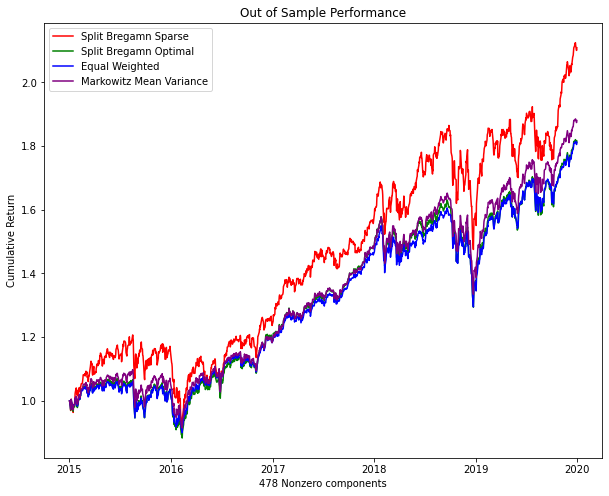

In [482]:
cum_returns_split_i=np.cumprod(1+np.dot(w2,returns_test.T))
cum_returns_split_j=np.cumprod(1+np.dot(wi,returns_test.T))
cum_returns_split_opt=np.cumprod(1+np.dot(w_opt,returns_test.T))


equal=(1/returns_test.shape[1])*np.ones(returns_test.shape[1])
cum_returns_equal=np.cumprod(1+np.dot(equal,returns_test.T))
fig,ax=plt.subplots(figsize=(10,8))
plt.title("Out of Sample Performance")
plt.plot(pd.to_datetime(returns_test.index),cum_returns_split_i,label='Split Bregamn Sparse',color='red')
plt.plot(pd.to_datetime(returns_test.index),cum_returns_split_j,label='Split Bregamn Optimal',color='green')
plt.plot(pd.to_datetime(returns_test.index),cum_returns_equal,label='Equal Weighted',color='blue')
plt.plot(pd.to_datetime(returns_test.index),cum_returns_split_opt,label='Markowitz Mean Variance',color='purple')
plt.xlabel(f"{len(wi[nonzero_wi])} Nonzero components")
plt.ylabel("Cumulative Return")
plt.legend()


In [480]:
def get_sharpe(port_returns,rf=0.0178):
    sd=np.std(port_returns)*np.sqrt(252)
    mu=np.mean(port_returns)*252
    
    sharpe=(mu-rf)/sd
    
    return sharpe

In [484]:
print(f"Sharpe of equal allocation is {round(get_sharpe(np.dot(equal,returns_test.T)),2)}")
print(f"Sharpe of Mean Variance allocation is {round(get_sharpe(np.dot(w_opt,returns_test.T)),2)}")
print(f"Sharpe of Split-Bregman Optimal allocation is {round(get_sharpe(np.dot(wi,returns_test.T)),2)}")
print(f"Sharpe of Split-Bregman Sparse allocation is {round(get_sharpe(np.dot(w1,returns_test.T)),2)}")


Sharpe of equal allocation is 0.83
Sharpe of Mean Variance allocation is 0.86
Sharpe of Split-Bregman Optimal allocation is 0.79
Sharpe of Split-Bregman Sparse allocation is 0.53
